# Separator

In [ ]:
import os
import pandas as pd
import shutil

def separate_audio_files(base_dir, protocol_file, output_dir):
    # Read the protocol file
    df = pd.read_csv(protocol_file, sep=' ', header=None, names=['SPEAKER_ID', 'AUDIO-FILE_NAME', 'SYSTEM_ID', 'KEY'])
    
    # Create directories for AI-generated and human-generated audio
    ai_generated_dir = os.path.join(output_dir, 'ai_generated')
    human_generated_dir = os.path.join(output_dir, 'human_generated')
    os.makedirs(ai_generated_dir, exist_ok=True)
    os.makedirs(human_generated_dir, exist_ok=True)
    
    # Iterate through the protocol file and copy files to the appropriate directory
    for index, row in df.iterrows():
        file_path = os.path.join(base_dir, row['SPEAKER_ID'] + '.flac')
        if row['KEY'] == 'spoof':
            shutil.copy(file_path, os.path.join(ai_generated_dir, row['SPEAKER_ID'] + '.flac'))
        else:
            shutil.copy(file_path, os.path.join(human_generated_dir, row['SPEAKER_ID'] + '.flac'))

# Example usage
train_base_dir = r'D:\Git Clones\CPE-313\Final Project\ASVSPOOF\LA\ASVspoof2019_LA_eval\flac'
train_protocol_file = r'D:\Git Clones\CPE-313\Final Project\ASVSPOOF\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.eval.trl.txt'
train_output_dir = r'D:\Git Clones\CPE-313\Final Project\Dataset\Evaluation'

separate_audio_files(train_base_dir, train_protocol_file, train_output_dir)

# Convert audio file into mel spectrogram

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def create_mel_spectrogram(file_path, save_path, n_mels=128, hop_length=512):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Create the Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_DB = librosa.power_to_db(S, ref=np.max)
    
    # Plot and save the Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def process_directory(input_dir, output_dir, n_mels=128, hop_length=512):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for subdir, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.flac'):
                file_path = os.path.join(subdir, file)
                output_file = os.path.join(output_dir, os.path.splitext(file)[0] + '.png')
                create_mel_spectrogram(file_path, output_file, n_mels=n_mels, hop_length=hop_length)
                print(f'Processed {file_path} -> {output_file}')

# Example usage
input_directory = r'D:\Git Clones\CPE-313\Final Project\Dataset\Evaluation\human_generated'
output_directory = r'D:\Git Clones\CPE-313\Final Project\Dataset\Evaluation\Mel Spectrogram\Real'
process_directory(input_directory, output_directory)


# Imports

In [4]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt 

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from keras.layers import Conv2D, MaxPooling2D, MaxPool2D,GlobalAveragePooling2D, LSTM
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models  import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.metrics import classification_report

# Image Data Generation

In [5]:
idg = ImageDataGenerator(rescale=1./255,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         validation_split= 0.2,
                         )

train_gen = idg.flow_from_directory(
    'D:\Git Clones\CPE-313\Final Project\Dataset\Mel Spectrogram\Balanced',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = True,
    subset='training'
)

valid_gen = idg.flow_from_directory(
    'D:\Git Clones\CPE-313\Final Project\Dataset\Mel Spectrogram\Balanced',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False,
    subset='validation'
)

Found 4128 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Plotting

In [7]:
def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='center right')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='center right')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.show()


# CNN

In [8]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [9]:
hist_cnn = cnn_model.fit(train_gen, epochs=20, validation_data = valid_gen, callbacks = early_stopping)

Epoch 1/20
129/129 [==============================] - 76s 564ms/step - loss: 0.6157 - accuracy: 0.7025 - val_loss: 0.3412 - val_accuracy: 0.8769
Epoch 2/20
129/129 [==============================] - 72s 557ms/step - loss: 0.3269 - accuracy: 0.8692 - val_loss: 0.2441 - val_accuracy: 0.9012
Epoch 3/20
129/129 [==============================] - 72s 557ms/step - loss: 0.2690 - accuracy: 0.8953 - val_loss: 0.2264 - val_accuracy: 0.9147
Epoch 4/20
129/129 [==============================] - 72s 555ms/step - loss: 0.2499 - accuracy: 0.9029 - val_loss: 0.2178 - val_accuracy: 0.9176
Epoch 5/20
129/129 [==============================] - 73s 563ms/step - loss: 0.2233 - accuracy: 0.9116 - val_loss: 0.1886 - val_accuracy: 0.9147
Epoch 6/20
129/129 [==============================] - 75s 584ms/step - loss: 0.2222 - accuracy: 0.9152 - val_loss: 0.1575 - val_accuracy: 0.9380
Epoch 7/20
129/129 [==============================] - 74s 573ms/step - loss: 0.1721 - accuracy: 0.9329 - val_loss: 0.1258 - val_ac

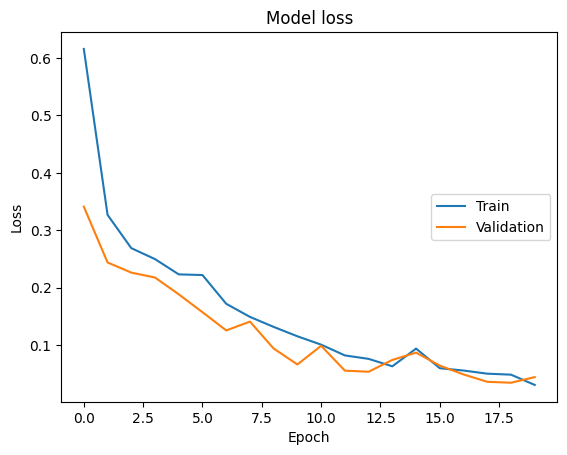

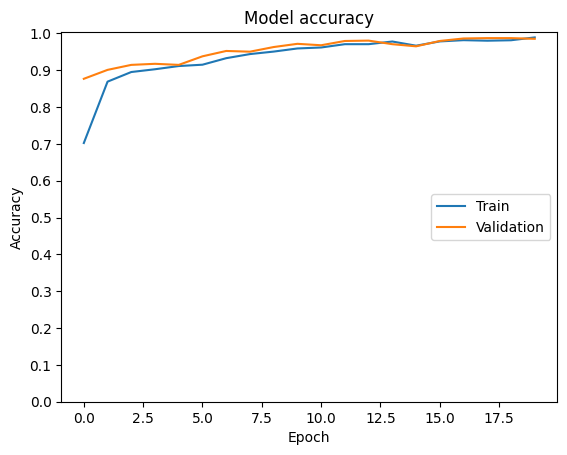

In [10]:
plot_training_history(hist_cnn)

In [48]:
# Get predictions
cnn_predictions = (cnn_model.predict(valid_gen) > 0.5).astype("int32").flatten()

# Get true labels
y_true = valid_gen.classes

# Print classification report
print(classification_report(y_true, cnn_predictions, target_names=['Fake', 'Real']))

33/33 [==============================] - 15s 455ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98       516
        Real       0.97      0.99      0.98       516

    accuracy                           0.98      1032
   macro avg       0.98      0.98      0.98      1032
weighted avg       0.98      0.98      0.98      1032



In [69]:
cnn_model.save('cnn_model_final1.h5')

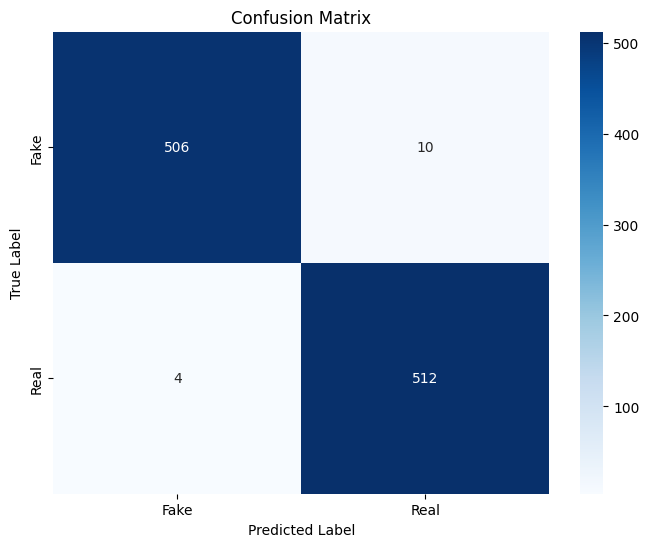

In [46]:
# Compute confusion matrix
cnn_cm = confusion_matrix(y_true, cnn_predictions)

# Plot confusion matrix
plot_confusion_matrix(cnn_cm, classes=['Fake', 'Real'])

# ResNet50

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

resnet_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

c:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [18]:
hist_resnet = resnet_model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks = early_stopping)

Epoch 1/30
129/129 [==============================] - 80s 597ms/step - loss: 0.6969 - accuracy: 0.5027 - val_loss: 0.7203 - val_accuracy: 0.5000
Epoch 2/30
129/129 [==============================] - 75s 578ms/step - loss: 0.6954 - accuracy: 0.5094 - val_loss: 0.6943 - val_accuracy: 0.4971
Epoch 3/30
129/129 [==============================] - 75s 578ms/step - loss: 0.6925 - accuracy: 0.5104 - val_loss: 0.6875 - val_accuracy: 0.5620
Epoch 4/30
129/129 [==============================] - 75s 581ms/step - loss: 0.6889 - accuracy: 0.5417 - val_loss: 0.6858 - val_accuracy: 0.5116
Epoch 5/30
129/129 [==============================] - 74s 575ms/step - loss: 0.6876 - accuracy: 0.5412 - val_loss: 0.6838 - val_accuracy: 0.5630
Epoch 6/30
129/129 [==============================] - 82s 632ms/step - loss: 0.6846 - accuracy: 0.5426 - val_loss: 0.6880 - val_accuracy: 0.5271
Epoch 7/30
129/129 [==============================] - 79s 610ms/step - loss: 0.6873 - accuracy: 0.5492 - val_loss: 0.6847 - val_ac

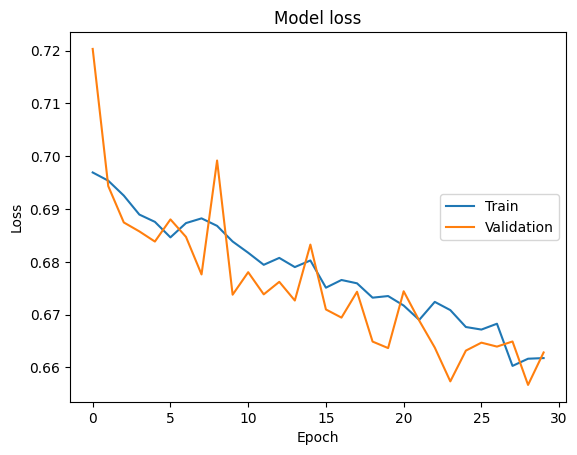

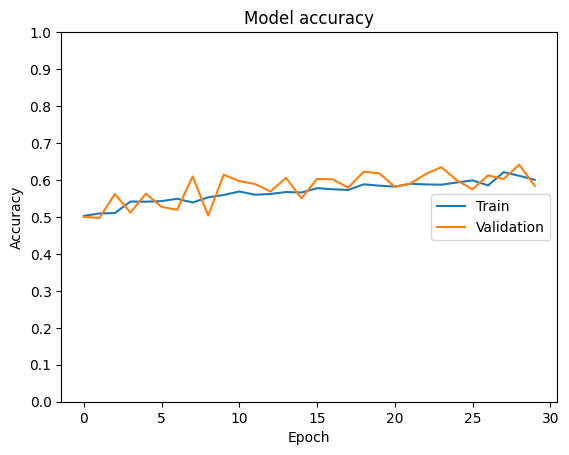

In [19]:
plot_training_history(hist_resnet)

In [49]:
from sklearn.metrics import classification_report

# Get predictions
resnet_predictions = (resnet_model.predict(valid_gen) > 0.5).astype("int32").flatten()

# Get true labels
y_true = valid_gen.classes

# Print classification report
print(classification_report(y_true, resnet_predictions, target_names=['Fake', 'Real']))


33/33 [==============================] - 15s 452ms/step
              precision    recall  f1-score   support

        Fake       0.54      0.88      0.67       516
        Real       0.68      0.26      0.38       516

    accuracy                           0.57      1032
   macro avg       0.61      0.57      0.52      1032
weighted avg       0.61      0.57      0.52      1032



In [21]:
resnet_loss, resnet_acc = resnet_model.evaluate(valid_gen)
print(f'ResNet Model - Loss: {resnet_loss}, Accuracy: {resnet_acc}')

33/33 [==============================] - 15s 450ms/step - loss: 0.6623 - accuracy: 0.5901
ResNet Model - Loss: 0.6623203754425049, Accuracy: 0.5901162624359131


In [36]:
resnet_model.save('resnet_model_final.h5')

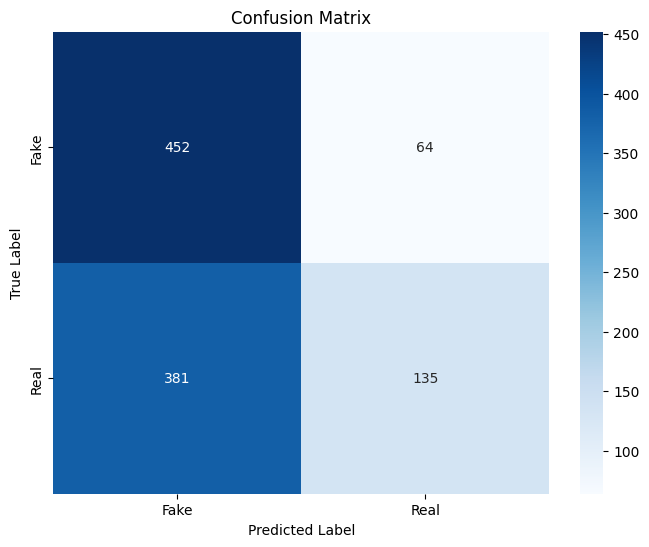

In [50]:
# Compute confusion matrix
resnet_cm = confusion_matrix(y_true, resnet_predictions)

# Plot confusion matrix
plot_confusion_matrix(resnet_cm, classes=['Fake', 'Real'])

# VGG16

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
vgg16_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()


58889256/58889256 [==============================] - 16s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

c:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
# Train the model
hist_vgg16 = vgg16_model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks = early_stopping)

Epoch 1/30
129/129 [==============================] - 84s 593ms/step - loss: 0.5267 - accuracy: 0.7299 - val_loss: 0.4006 - val_accuracy: 0.8266
Epoch 2/30
129/129 [==============================] - 73s 569ms/step - loss: 0.3785 - accuracy: 0.8396 - val_loss: 0.3257 - val_accuracy: 0.8731
Epoch 3/30
129/129 [==============================] - 74s 569ms/step - loss: 0.3285 - accuracy: 0.8716 - val_loss: 0.3209 - val_accuracy: 0.8740
Epoch 4/30
129/129 [==============================] - 74s 572ms/step - loss: 0.3125 - accuracy: 0.8704 - val_loss: 0.3162 - val_accuracy: 0.8740
Epoch 5/30
129/129 [==============================] - 75s 583ms/step - loss: 0.2789 - accuracy: 0.8881 - val_loss: 0.2455 - val_accuracy: 0.9109
Epoch 6/30
129/129 [==============================] - 76s 585ms/step - loss: 0.2566 - accuracy: 0.9016 - val_loss: 0.2464 - val_accuracy: 0.9041
Epoch 7/30
129/129 [==============================] - 76s 586ms/step - loss: 0.2419 - accuracy: 0.9082 - val_loss: 0.2217 - val_ac

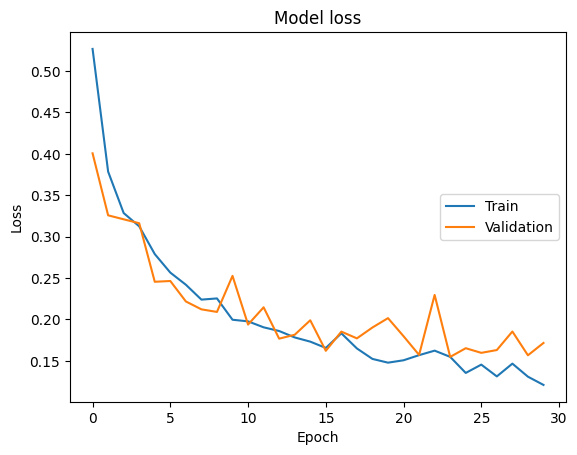

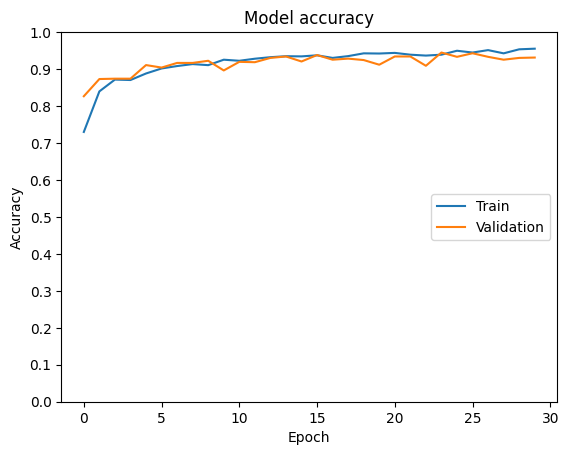

In [29]:
plot_training_history(hist_vgg16)

In [68]:
vgg16_predictions = (vgg16_model.predict(valid_gen) > 0.5).astype("int32").flatten()

y_true = valid_gen.classes

print(classification_report(y_true, vgg16_predictions, target_names=['Fake', 'Real']))

33/33 [==============================] - 23s 709ms/step
              precision    recall  f1-score   support

        Fake       0.91      0.96      0.93       516
        Real       0.96      0.90      0.93       516

    accuracy                           0.93      1032
   macro avg       0.93      0.93      0.93      1032
weighted avg       0.93      0.93      0.93      1032



In [71]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(valid_gen)
print(f'ResNet Model - Loss: {vgg16_loss}, Accuracy: {vgg16_acc}')

33/33 [==============================] - 22s 624ms/step - loss: 0.1657 - accuracy: 0.9419
ResNet Model - Loss: 0.1656920164823532, Accuracy: 0.9418604373931885


In [70]:
vgg16_model.save('vgg16_model_final1.h5')

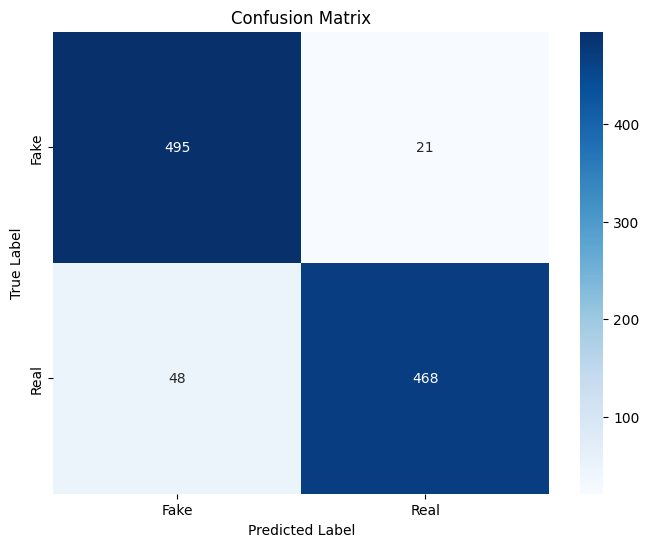

In [52]:
# Compute confusion matrix
vgg16_cm = confusion_matrix(y_true, vgg16_predictions)

# Plot confusion matrix
plot_confusion_matrix(vgg16_cm, classes=['Fake', 'Real'])

# Testing for unforeseen data

## Image Data Gen for unforeseen data

In [57]:
eval_idg = ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              validation_split= 0.2,
                              )

eval_train_gen = idg.flow_from_directory(
    'D:\Git Clones\CPE-313\Final Project\Dataset\Eval_Balanced',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = True,
    subset='training'
)

eval_valid_gen = idg.flow_from_directory(
    'D:\Git Clones\CPE-313\Final Project\Dataset\Eval_Balanced',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False,
    subset='validation'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


## Loading the model

In [58]:
from tensorflow.keras.models import load_model

### CNN

In [59]:
cnn_modelh5 = load_model('cnn_model_final.h5')

In [60]:
cnnh5_predictions = (cnn_modelh5.predict(eval_valid_gen) > 0.5).astype("int32").flatten()

y_true = eval_valid_gen.classes

print(classification_report(y_true, cnnh5_predictions, target_names=['Fake', 'Real']))

13/13 [==============================] - 11s 702ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.71      0.83       200
        Real       0.77      0.99      0.87       200

    accuracy                           0.85       400
   macro avg       0.88      0.85      0.85       400
weighted avg       0.88      0.85      0.85       400



In [72]:
loss, acc = cnn_modelh5.evaluate(eval_valid_gen)
print(f'CNN Model - Loss: {loss}, Accuracy: {acc}')

13/13 [==============================] - 11s 654ms/step - loss: 0.7336 - accuracy: 0.8625
CNN Model - Loss: 0.7335612773895264, Accuracy: 0.862500011920929


### ResNet

In [61]:
resnet_modelh5 = load_model('resnet_model_final.h5')

In [62]:
resneth5_predictions = (resnet_modelh5.predict(eval_valid_gen) > 0.5).astype("int32").flatten()

y_true = eval_valid_gen.classes

print(classification_report(y_true, resneth5_predictions, target_names=['Fake', 'Real']))

13/13 [==============================] - 11s 629ms/step
              precision    recall  f1-score   support

        Fake       0.54      0.89      0.67       200
        Real       0.69      0.26      0.38       200

    accuracy                           0.57       400
   macro avg       0.62      0.57      0.53       400
weighted avg       0.62      0.57      0.53       400



In [73]:
loss, acc = resnet_modelh5.evaluate(eval_valid_gen)
print(f'ResNet Model - Loss: {loss}, Accuracy: {acc}')

13/13 [==============================] - 11s 565ms/step - loss: 0.6676 - accuracy: 0.5575
ResNet Model - Loss: 0.6675506830215454, Accuracy: 0.5575000047683716


### VGG16

In [63]:
vgg16_modelh5 = load_model('vgg16_model_final.h5')

In [67]:
vgg16h5_predictions = (vgg16_modelh5.predict(eval_valid_gen) > 0.5).astype("int32").flatten()

y_true = eval_valid_gen.classes

print(classification_report(y_true, vgg16h5_predictions, target_names=['Fake', 'Real']))

13/13 [==============================] - 12s 934ms/step
              precision    recall  f1-score   support

        Fake       0.87      0.89      0.88       200
        Real       0.88      0.87      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [74]:
loss, acc = vgg16_modelh5.evaluate(eval_valid_gen)
print(f'VGG16 Model - Loss: {loss}, Accuracy: {acc}')

13/13 [==============================] - 8s 555ms/step - loss: 0.3195 - accuracy: 0.8450
VGG16 Model - Loss: 0.31946083903312683, Accuracy: 0.8450000286102295
